In [70]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



# 1. Data Preprocessing:

## Loading and Log Transformation

In [74]:
response = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/drug_response_classifications.csv')
response

,Sample ID,Dataset,Response
0,PIK3CA-1113,MGH_Alpelisib,Responder
1,MGHCC1099,MGH_Ribociclib,Responder
2,MGHCC1573,MGH_Ribociclib,Non-responder
3,PIK3CA-0036,MGH_Alpelisib,Responder
4,PIK3CA-1039,MGH_Alpelisib,Responder
...,...,...,...
1002,Pt92_On,Anti-PD1,Non-responder
1003,Pt93_On,Anti-PD1,Non-responder
1004,Pt94_On,Anti-PD1,Responder
1005,Pt98_On,Anti-PD1,Non-responder


In [72]:
df_1 = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Anti-PD1 +- Anti-CTLA4.csv')
df_2 = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Sorafenib_2.csv')
df_3 = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Anti-PD1_3.csv')
df_4 = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Anti-PD1_4.csv')
df_5= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Anti-PD1.csv')
df_6= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Bevacizumab_2.csv')
df_7= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Bevacizumab_3.csv')
df_8= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Bevacizumab_4.csv')
df_9= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Bevacizumab.csv')
df_10= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Cetuximab.csv')
df_11= pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Sorafenib.csv')
df_12 = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/Anti-PD1_2.csv')

In [42]:
df_1

,ID_REF,GSM4190059,GSM4190065,GSM4190066,GSM4190068,GSM4190071,GSM4190078,GSM4190079,GSM4190080,GSM4190082
0,A2M,12.785586,13.678685,12.108865,15.752751,13.802375,15.334545,11.681593,12.108865,11.341789
1,ABCB1,9.859458,8.742550,10.444022,11.681593,10.746376,11.541394,11.515712,11.175926,10.010097
2,ABCF1,10.250885,10.865115,9.993066,9.189720,9.429981,9.063804,10.388532,9.773340,9.006495
3,ABL1,9.959460,9.773340,9.380835,9.220878,8.429518,8.880946,9.127771,9.036491,9.282655
4,ADA,10.165893,8.583587,8.577517,8.118660,8.692783,8.142801,8.612440,8.132091,8.860275
...,...,...,...,...,...,...,...,...,...,...
779,ZC3H14,10.004070,9.445864,10.195729,9.541990,9.329577,9.412542,10.637052,9.767404,9.877791
780,ZKSCAN5,7.135686,7.022776,8.023784,7.036163,6.651771,7.041291,8.031403,7.661578,7.963741
781,ZNF143,7.194493,8.536919,8.909842,7.944005,8.126243,7.685305,8.287718,8.137469,9.111960
782,ZNF205,7.407767,8.047823,7.222019,6.788112,7.107984,5.289422,7.939464,7.131815,7.490078


In [75]:
df_12 = df_12.rename(columns={'symbol': 'index'})
df_1 = df_1.rename(columns={'ID_REF': 'index'})

In [76]:
df_12_log = df_12.copy()
df_12_log['index'] = df_12['index']  # Ensure 'index' is present
df_12_log = np.log2(df_12_log.drop(columns=['index']) + 1)
df_12_log.insert(0, 'index', df_12['index'])  # Reinsert 'index' as the first column

df_11_log = df_11.copy()
df_11_log['index'] = df_11['index']
df_11_log = np.log2(df_11_log.drop(columns=['index']) + 1)
df_11_log.insert(0, 'index', df_11['index'])

df_10_log = df_10.copy()
df_10_log['index'] = df_10['index']
df_10_log = np.log2(df_10_log.drop(columns=['index']) + 1)
df_10_log.insert(0, 'index', df_10['index'])

df_6_log = df_6.copy()
df_6_log['index'] = df_6['index']
df_6_log = np.log2(df_6_log.drop(columns=['index']) + 1)
df_6_log.insert(0, 'index', df_6['index'])

df_5_log = df_5.copy()
df_5_log['index'] = df_5['index']
df_5_log = np.log2(df_5_log.drop(columns=['index']) + 1)
df_5_log.insert(0, 'index', df_5['index'])

In [77]:
df_5 = df_5_log
df_6 = df_6_log
df_11 = df_11_log
df_10 = df_10_log
df_12 = df_12_log

In [78]:
df_9.columns

Index(['index', 'GSM496016', 'GSM496019', 'GSM496020', 'GSM496021',
       'GSM496023', 'GSM496032', 'GSM496036', 'GSM496037', 'GSM496040',
       'GSM496041', 'GSM496042', 'GSM496043'],
      dtype='object')

In [101]:
df_list = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12]
scaler = MinMaxScaler()
transformed_dfs = []

for i, df_i in enumerate(df_list, start=1):
    
    df_i_scaled = df_i.copy()
    
    numeric_columns = df_i_scaled.select_dtypes(include=['float64', 'int64']).columns
    df_i_scaled[numeric_columns] = scaler.fit_transform(df_i_scaled[numeric_columns])
    
    df_i_transposed = df_i_scaled.set_index('index').T
    df_i_transposed = df_i_transposed.reset_index()
    df_i_transposed = df_i_transposed.rename(columns={'index': 'Sample ID'})
    
    # Append the scaled and transposed DataFrame to the list
    transformed_dfs.append(df_i_transposed)

# Concatenate all scaled and transposed DataFrames
df_merged_2 = pd.concat(transformed_dfs, axis=0, ignore_index=True, join='outer')

In [102]:
df_merged_2 = df_merged_2.merge(response[['Sample ID', 'Response']], on='Sample ID', how='left')
df_merged_2

,Sample ID,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,...,TSPOAP1,CILK1,TIGAR,ARMH1,RAMAC,REXO5,H1-2,ABRAXAS2,TEPSIN,Response
0,GSM4190059,0.736643,0.525803,0.554007,0.533008,0.547883,0.565606,0.479948,0.082157,0.427638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non-responder
1,GSM4190065,0.803996,0.453689,0.604323,0.526842,0.442407,0.399992,0.498986,0.104715,0.438268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Responder
2,GSM4190066,0.692589,0.574439,0.542435,0.498986,0.441977,0.414968,0.493476,0.127780,0.411257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Responder
3,GSM4190068,0.951188,0.662267,0.485423,0.487635,0.409412,0.375003,0.454391,0.097789,0.353569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Responder
4,GSM4190071,0.812774,0.595896,0.502474,0.431473,0.450157,0.373909,0.481460,0.080488,0.362681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Responder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,SRR8281245,0.788422,0.389991,0.560166,0.629279,0.441675,NaN,0.513888,NaN,NaN,...,0.385654,0.452334,0.436910,0.335896,0.427392,0.326968,0.394099,0.475552,0.503405,Responder
366,SRR8281251,0.791018,0.525784,0.630977,0.673474,0.446848,NaN,0.538852,NaN,NaN,...,0.572157,0.591457,0.461601,0.274027,0.396401,0.415280,0.435713,0.513336,0.481498,Responder
367,SRR8281238,0.824016,0.481394,0.544103,0.616098,0.456337,NaN,0.490011,NaN,NaN,...,0.545256,0.594772,0.429127,0.346286,0.399956,0.305685,0.470213,0.423791,0.456952,Responder
368,SRR8281239,0.858961,0.575003,0.603988,0.672309,0.501577,NaN,0.571097,NaN,NaN,...,0.522555,0.584109,0.511400,0.409968,0.395518,0.375322,0.559949,0.492922,0.512638,Responder


In [103]:
duplicate_counts = df_merged_2['Sample ID'].value_counts()
print(duplicate_counts[duplicate_counts > 1])

Series([], Name: count, dtype: int64)


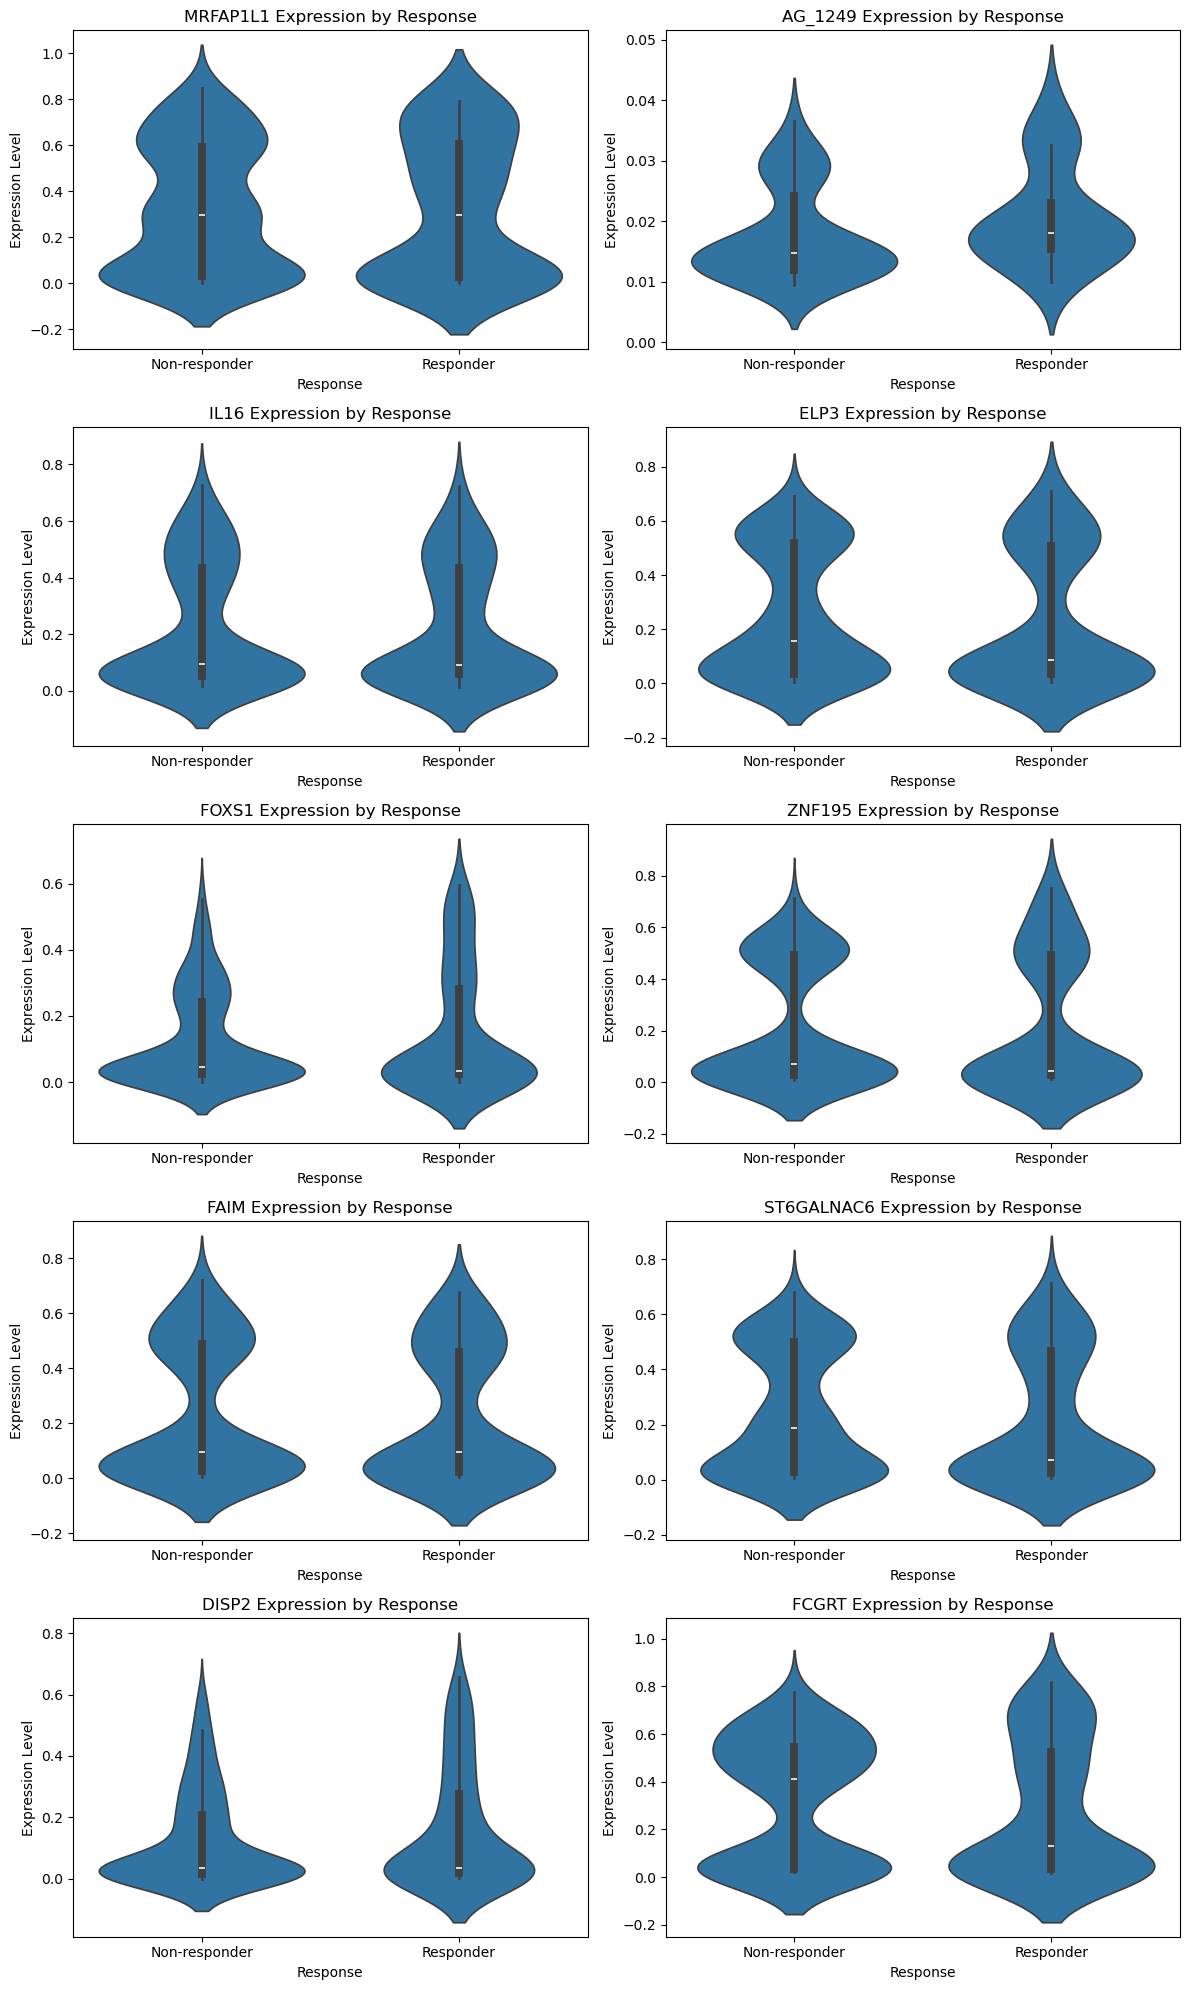

In [83]:
top_gene = ['MRFAP1L1', 'AG_1249', 'IL16', 'ELP3', 'FOXS1', 'ZNF195', 'FAIM', 'ST6GALNAC6', 'DISP2', 'FCGRT']
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Loop through the top10_gene list and plot each gene's expression in a subplot
for i, gene in enumerate(top_gene):
    sns.violinplot(x=df_merged_2['Response'], y=df_merged_2[gene], ax=axes[i])
    axes[i].set_title(f'{gene} Expression by Response')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Expression Level')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [104]:
df_merged_2['Response'] = df_merged_2['Response'].map({'Non-responder':0,'Responder':1})

In [105]:
df_merged_2['Response'].value_counts()

Response
0    223
1    147
Name: count, dtype: int64

In [106]:
df_merged_2.loc[df_merged_2.Response.isna()==True]

,Sample ID,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,...,TSPOAP1,CILK1,TIGAR,ARMH1,RAMAC,REXO5,H1-2,ABRAXAS2,TEPSIN,Response


In [107]:
df_merged_2.isna().sum()

Sample ID      0
A2M            0
ABCB1          0
ABCF1          0
ABL1           0
            ... 
REXO5        355
H1-2         355
ABRAXAS2     355
TEPSIN       355
Response       0
Length: 38531, dtype: int64

In [108]:
df_merged_2 = df_merged_2.loc[:, df_merged_2.isna().sum() <=300]

In [109]:
df_merged_2.fillna(0, inplace=True)

/var/folders/ys/kt70q71j7gz446l2lbpzjg9c0000gn/T/ipykernel_18988/1531317506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_2.fillna(0, inplace=True)


In [113]:
columns_with_slashes = [col for col in df_merged_2.columns if '/' in col]

# Print the columns that contain '/'
if columns_with_slashes:
    print("Columns containing '/' :", columns_with_slashes)
else:
    print("No columns contain '/'.")

Columns containing '/' : ['OK/SW-CL.36', 'OK/SW-CL.58']


In [116]:
columns_with_slashes = [col for col in df_merged_2.columns if '-' in col]

# Print the columns that contain '/'
if columns_with_slashes:
    print("Columns containing '-' :", columns_with_slashes)
else:
    print("No columns contain '-'.")

Columns containing '-' : ['HLA-A', 'HLA-B', 'HLA-C', 'HLA-DMA', 'HLA-DMB', 'HLA-DOB', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRA', 'HLA-DRB3', 'HLA-DRB4', 'HLA-E', 'HLA-G', 'AATK-AS1', 'ACTA2-AS1', 'ADORA2A-AS1', 'AFAP1-AS1', 'AGPAT4-IT1', 'ANP32A-IT1', 'APITD1-CORT', 'APOC4-APOC2', 'AQP4-AS1', 'ARHGAP19-SLIT1', 'ARHGAP5-AS1', 'ASB16-AS1', 'ASMTL-AS1', 'ATP6V0E2-AS1', 'BAIAP2-AS1', 'BIN3-IT1', 'C15orf38-AP3S2', 'C1QTNF9B-AS1', 'C1RL-AS1', 'C20orf166-AS1', 'CACTIN-AS1', 'CATX-1', 'CCDC148-AS1', 'CEBPA-AS1', 'CECR5-AS1', 'CELF2-AS1', 'CHURC1-FNTB', 'CIRBP-AS1', 'CLTC-IT1', 'COL18A1-AS1', 'CORO7-PAM16', 'CPS1-IT1', 'CRHR1-IT1', 'CRYM-AS1', 'CSNK1G2-AS1', 'CTBP1-AS2', 'CYP1B1-AS1', 'DAOA-AS1', 'DDC-AS1', 'DHRS4-AS1', 'DIAPH2-AS1', 'DICER1-AS1', 'DLG5-AS1', 'DLGAP1-AS1', 'DNAJC25-GNG10', 'DTX2P1-UPK3BP1-PMS2P11', 'EHMT1-IT1', 'EIF3J-AS1', 'ELOVL2-AS1', 'EMC3-AS1', 'EPB41L4A-AS1', 'EPB41L4A-AS2', 'ERC2-IT1', 'ERV3-1', 'ERVFRD-1', 'ERVH-4', 'ERVH-6', 'ERVK13-1', 'ERVK3-2', 'ERVM

In [118]:
krtap_genes = [gene for gene in df_merged_2.columns if 'KRTAP' in gene]

print(krtap_genes)

['KRTAP1-1', 'KRTAP1-3', 'KRTAP1-4', 'KRTAP1-5', 'KRTAP10-1', 'KRTAP10-10', 'KRTAP10-11', 'KRTAP10-12', 'KRTAP10-2', 'KRTAP10-3', 'KRTAP10-4', 'KRTAP10-5', 'KRTAP10-7', 'KRTAP10-8', 'KRTAP10-9', 'KRTAP11-1', 'KRTAP12-1', 'KRTAP12-2', 'KRTAP12-3', 'KRTAP12-4', 'KRTAP13-1', 'KRTAP13-2', 'KRTAP13-3', 'KRTAP13-4', 'KRTAP15-1', 'KRTAP17-1', 'KRTAP19-1', 'KRTAP19-2', 'KRTAP19-3', 'KRTAP19-4', 'KRTAP19-5', 'KRTAP19-6', 'KRTAP19-7', 'KRTAP19-8', 'KRTAP2-1', 'KRTAP2-3', 'KRTAP2-4', 'KRTAP20-1', 'KRTAP20-2', 'KRTAP20-3', 'KRTAP20-4', 'KRTAP21-1', 'KRTAP21-2', 'KRTAP22-1', 'KRTAP23-1', 'KRTAP24-1', 'KRTAP26-1', 'KRTAP27-1', 'KRTAP3-1', 'KRTAP3-2', 'KRTAP3-3', 'KRTAP4-1', 'KRTAP4-11', 'KRTAP4-12', 'KRTAP4-2', 'KRTAP4-3', 'KRTAP4-4', 'KRTAP4-5', 'KRTAP4-6', 'KRTAP4-9', 'KRTAP5-1', 'KRTAP5-10', 'KRTAP5-11', 'KRTAP5-2', 'KRTAP5-3', 'KRTAP5-4', 'KRTAP5-5', 'KRTAP5-6', 'KRTAP5-7', 'KRTAP5-9', 'KRTAP5-AS1', 'KRTAP6-1', 'KRTAP6-2', 'KRTAP6-3', 'KRTAP7-1', 'KRTAP8-1', 'KRTAP9-2', 'KRTAP9-3', 'KRTAP9-4', '

In [ ]:
snord_genes = [gene for gene in df_merged_2.columns if 'SNORD' in gene]

snord_df = df_merged[snord_genes]

df_merged_2['SNORD'] = snord_df.mean(axis=1)

# Optionally, drop the original columns if you no longer need them
df_merged_2= df_merged_2.drop(columns=snord_genes, inplace=True)

In [124]:
from scipy.stats import ttest_ind

df_krtap = df_merged_2[krtap_genes + ['Response']]  # Add response column for comparison

# Separate the data into responders (1) and non-responders (0)
responders = df_krtap[df_krtap['Response'] == 1].drop(columns=['Response'])
non_responders = df_krtap[df_krtap['Response'] == 0].drop(columns=['Response'])

# Perform t-test for each gene
p_values = []
for gene in krtap_genes:
    _, p_value = ttest_ind(responders[gene], non_responders[gene], equal_var=False)
    p_values.append(p_value)

# Create a DataFrame to view the p-values
p_value_df = pd.DataFrame({'Gene': krtap_genes, 'p_value': p_values})
p_value_df_sorted = p_value_df.sort_values(by='p_value', ascending=False)

print(p_value_df.head(10))

         Gene   p_value
0    KRTAP1-1  0.855349
1    KRTAP1-3  0.000161
2    KRTAP1-4  0.299626
3    KRTAP1-5  0.839038
4   KRTAP10-1  0.015038
5  KRTAP10-10  0.001484
6  KRTAP10-11  0.001501
7  KRTAP10-12  0.002186
8   KRTAP10-2  0.029163
9   KRTAP10-3  0.000158


In [126]:
list = ['OK/SW-CL.36', 'OK/SW-CL.58', '1-Dec', '1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Mar',
        '11-Sep', '12-Sep', '14-Sep', '15-Sep', '2-Mar', '2-Sep', '3-Mar', '3-Sep', '4-Mar', 
        '4-Sep', '5-Mar', '5-Sep', '6-Mar', '6-Sep', '7-Mar', '7-Sep', '8-Mar', '8-Sep', '9-Mar', 
        '9-Sep']

for col in list:
    if col in df_merged_2.columns:
        df_merged_2=df_merged_2.drop(col, axis=1, inplace=True)

In [131]:
df_merged_2.columns

Index(['Sample ID', 'A2M', 'ABCB1', 'ABCF1', 'ABL1', 'ADA', 'ADORA2A', 'AGK',
       'AICDA', 'AIRE',
       ...
       'DNAJC27-AS1', 'LINC00886', 'LOC730102', 'LINC01136', 'LINC01220',
       'LOC731424', 'OR7E2P', 'FAM95A', 'Response', 'SNORD'],
      dtype='object', length=25931)

In [133]:
df_merged_2.to_csv('breast_cancer_mRNA_data_2.csv', index=False)

In [136]:
df = pd.concat([df_merged, df_merged_2], axis=0, ignore_index=True, join='outer')

In [142]:
cols = ['NEG_A','NEG_B','NEG_C','NEG_D','NEG_E','NEG_F','POS_A','POS_B','POS_C','POS_D','POS_F']
df = df.drop(columns=cols, axis=1)

In [144]:
cols = ['KIR_Activating_Subgroup_1','KIR_Activating_Subgroup_2','KIR_Inhibiting_Subgroup_1','KIR_Inhibiting_Subgroup_2','POS_E']
df = df.drop(columns=cols, axis=1)

In [147]:
df.fillna(0, inplace=True)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Columns: 38516 entries, Sample ID to SNORD
dtypes: float64(38515), object(1)
memory usage: 217.5+ MB


In [169]:
integer_columns = [col for col in df.columns if str(col).isdigit()]

print("Integer columns:", integer_columns)

Integer columns: ['40969', '40970', '40971', '40972', '40973', '40974', '40975', '40976', '40977', '40978', '40979', '41153', '41154', '41155', '41156', '41157', '41158', '41159', '41160', '41161', '41162', '41163', '41164', '41166', '41167', '41244']


In [170]:
df = df.drop(columns=integer_columns, axis=1)

In [204]:
df.to_csv('breast_cancer_mRNA_data_sum.csv', index=False)

# Exploratory Data Analysis (EDA)

## Feature Engineering

## Identify the top 10 feature genes

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import make_column_transformer  
from sklearn.pipeline import make_pipeline  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Scaling

In [171]:

X = df.drop(columns=['Sample ID','Response'], axis=1)
y = df['Response']  
X.columns = X.columns.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [172]:
# Get feature importance from the trained model
feature_importance = rf.feature_importances_

# Create a DataFrame with gene names (assuming columns in X are gene names)
feature_df = pd.DataFrame({
    'Gene': X.columns,  # Assuming X is a DataFrame with gene names as columns
    'Importance': feature_importance
})

# Sort by importance in descending order
top_genes = feature_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 important genes
print(top_genes)

              Gene  Importance
38487        SNORD    0.008924
19601     SNORD58A    0.004137
19478    SNORD103A    0.003509
27114        8-Mar    0.003323
12467  OK/SW-CL.36    0.003308
19526   SNORD116-2    0.003067
26759      SNORD89    0.002958
27110        6-Mar    0.002922
550          NEG_G    0.002890
551          NEG_H    0.002839


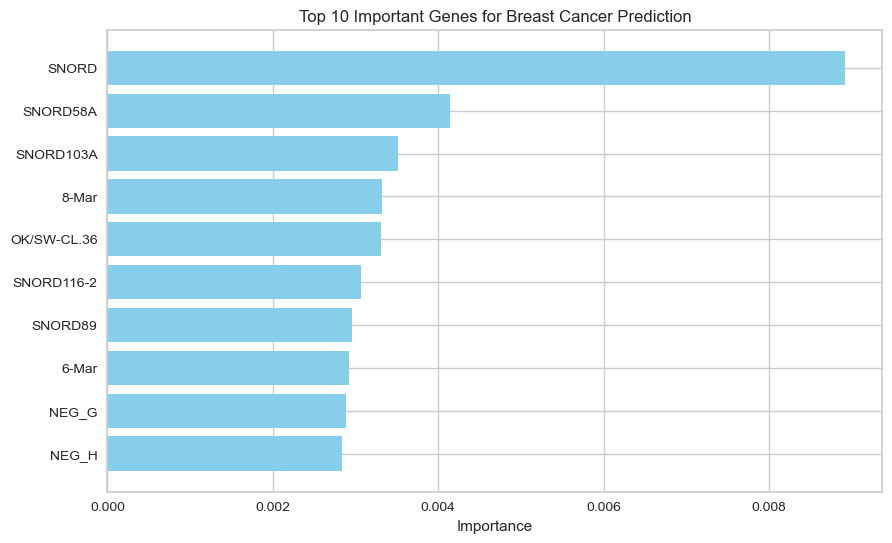

In [173]:
# Plot the top 10 important genes
plt.figure(figsize=(10, 6))
plt.barh(top_genes['Gene'], top_genes['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important Genes for Breast Cancer Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important gene at the top
plt.show()

In [159]:
genes=[]
for gene in top_genes.Gene:
    genes.append(gene)

print(genes)


['SNORD104', 'OK/SW-CL.36', 'SNORD15A', 'SNORD48', 'NEG_G', 'SNORD', '9-Sep', 'SNORD17', '11-Mar', 'NEG_H']


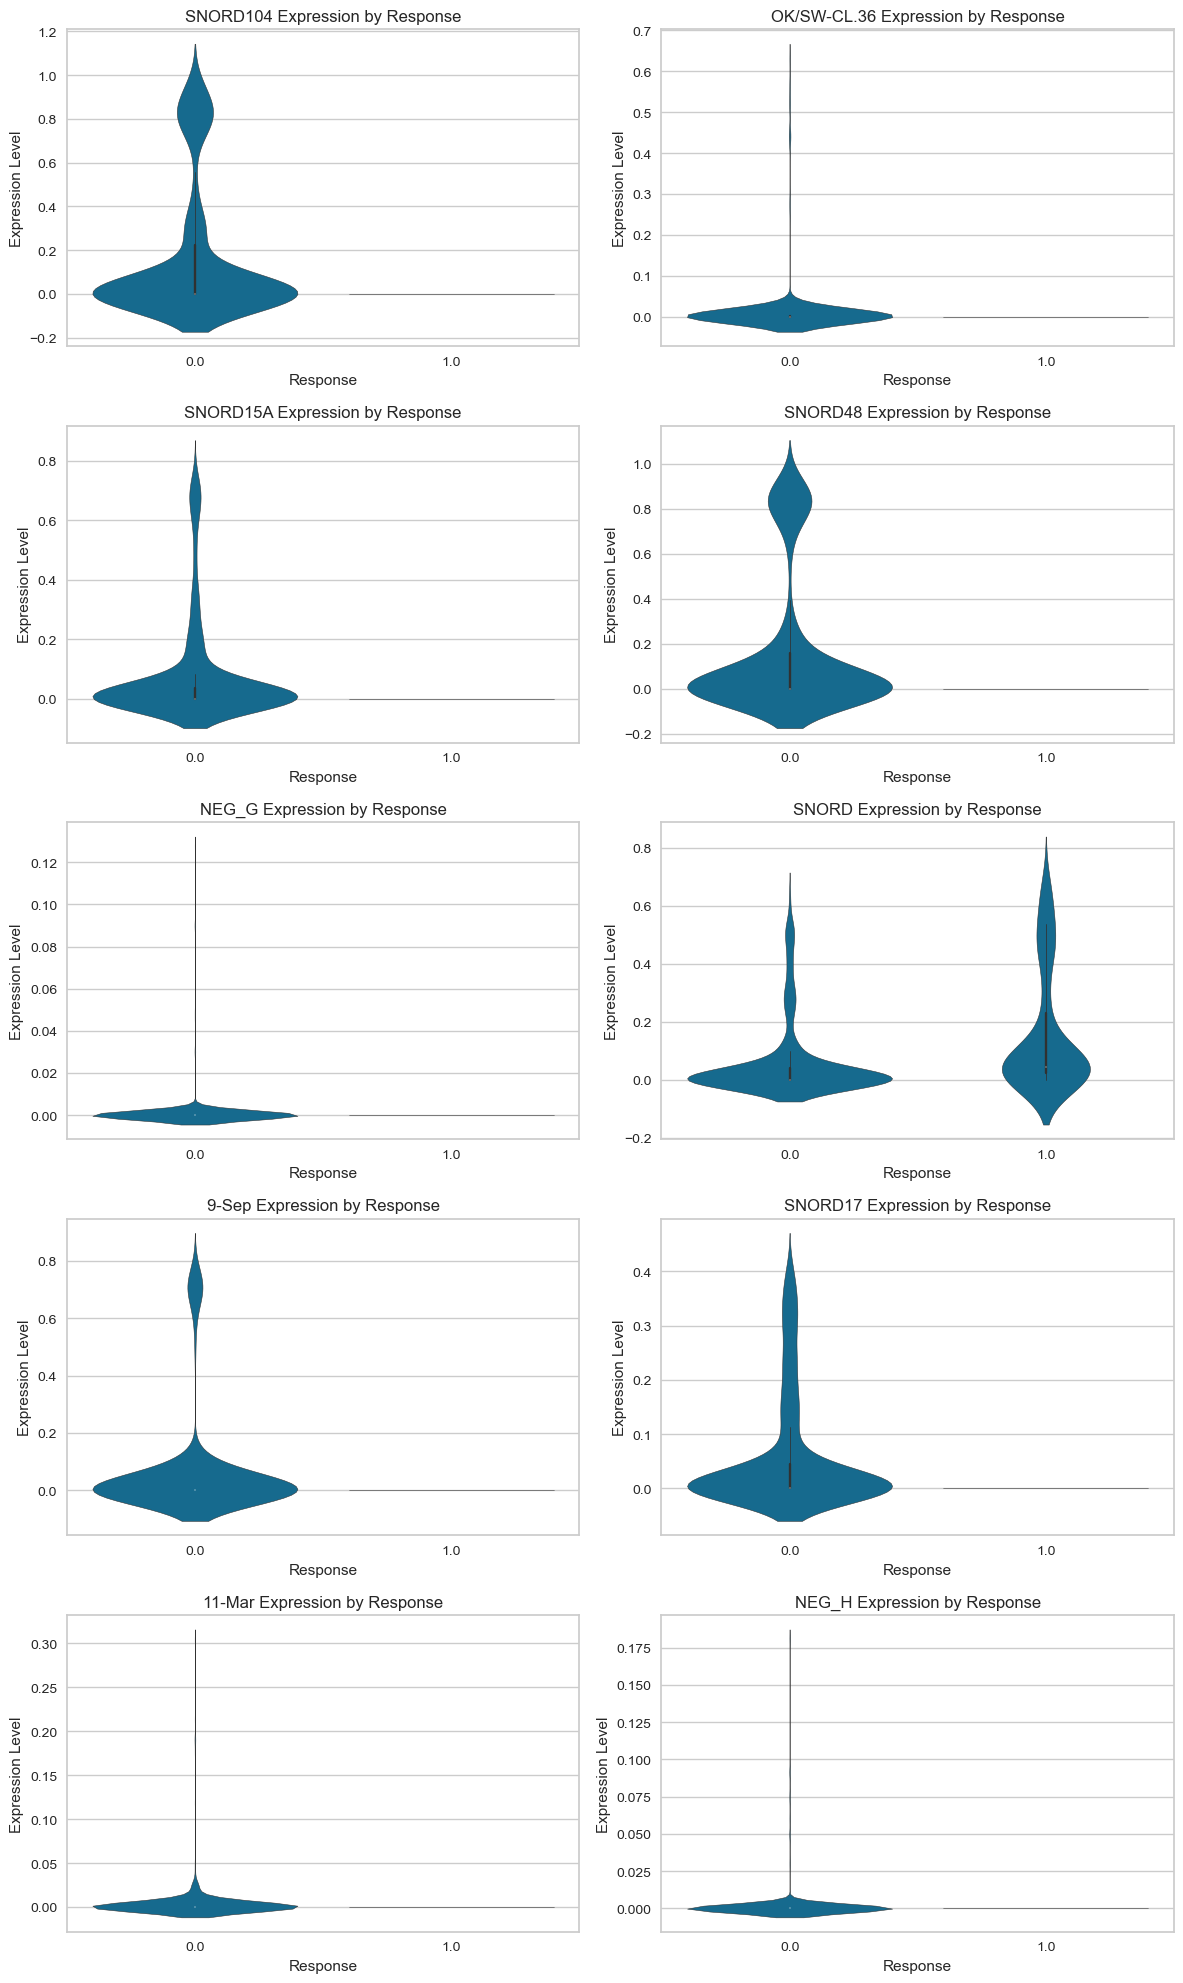

In [176]:
top10_gene = genes
fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Loop through the top10_gene list and plot each gene's expression in a subplot
for i, gene in enumerate(top10_gene):
    sns.violinplot(x=df['Response'], y=df[gene], ax=axes[i])
    axes[i].set_title(f'{gene} Expression by Response')
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Expression Level')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [31]:
genes_of_interest = [
    "ERBB2", "BRCA1", "BRCA2", "TP53", "ER", "PR", "Ki-67", "EGFR", 
    "CTLA4", "CD44", "MMPs", "PIK3CA", "FOXM1", "AKT1", "PTEN"
]

genes_in_data = [gene for gene in genes_of_interest if gene in df_merged.index]
genes_in_data

[]

## Dimensionality Reduction (PCA)

In [177]:
X = df.drop(columns=['Sample ID','Response'], axis=1)
X.columns = X.columns.astype(str)
scaler = StandardScaler()
decomp = PCA(n_components = 0.9)
pipe = make_pipeline(scaler, decomp)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9))])

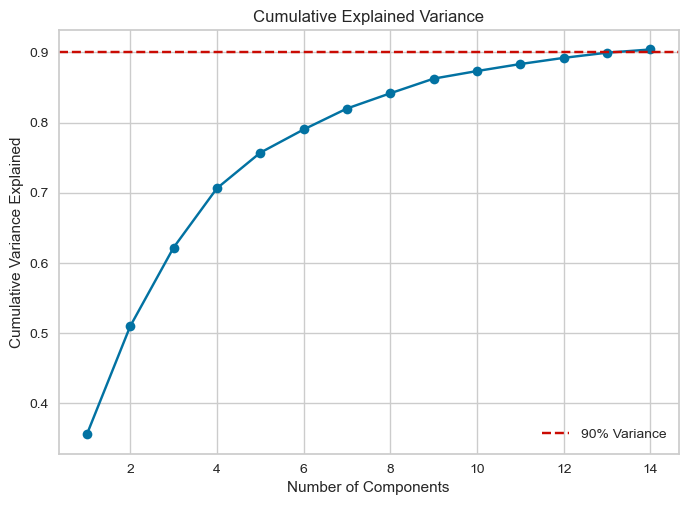

In [178]:

pca = pipe.named_steps['pca']

cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.show()

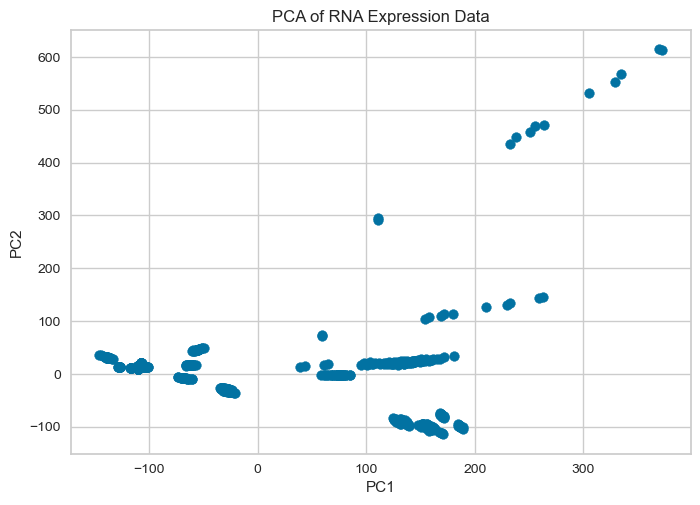

In [179]:
pca_result = pipe.transform(X)

# Now, plot the first two principal components
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of RNA Expression Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [180]:
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")

Explained variance ratio: [0.3555897  0.15413226 0.11202317 0.08450742 0.05071886 0.03306095
 0.02990633 0.02168472 0.02088782 0.01079545 0.00999328 0.0087953
 0.00737161 0.00456334]
Cumulative explained variance: [0.3555897  0.50972196 0.62174513 0.70625255 0.75697141 0.79003236
 0.81993869 0.84162341 0.86251122 0.87330668 0.88329996 0.89209525
 0.89946686 0.9040302 ]


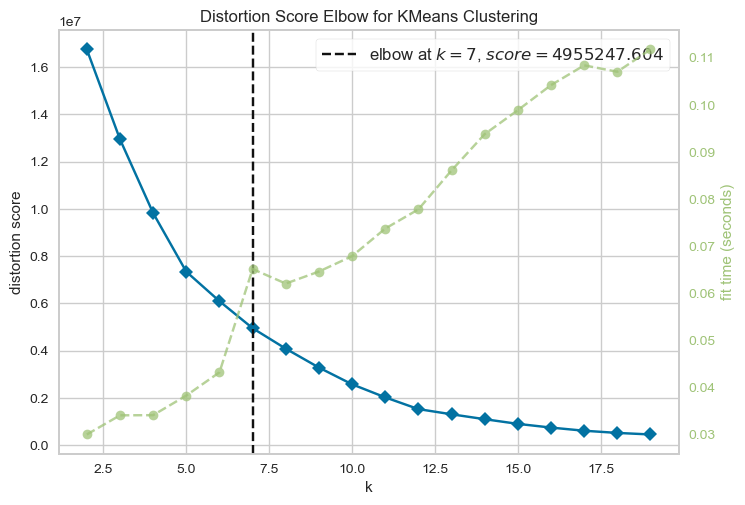

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [181]:
scaler = StandardScaler()
decomp = PCA(n_components=0.9)
cluster = KElbowVisualizer(KMeans(n_init=20),k=(2, 20))  # how many times the model runs, 10 is the default value
pipe = make_pipeline(scaler, decomp, cluster)

pipe.fit(X)
pipe[2].show()

In [189]:
scaler = StandardScaler()
decomp = PCA(n_components=.9)
cluster = KMeans(n_init=10, n_clusters=4)
pipe= make_pipeline(scaler, decomp, cluster)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9)),
                ('kmeans', KMeans(n_clusters=4, n_init=10))])

In [190]:
values = pipe[:2].transform(X)
pca_labels = [f'PC{idx+1}' for idx, i in enumerate(values.T)]
df_pca = df.join(pd.DataFrame(values, columns=pca_labels))

df_pca['clusters'] = pipe['kmeans'].labels_

In [191]:
df_pca.columns

Index(['Sample ID',       'A2M',     'ABCB1',     'ABCF1',      'ABL1',
             'ADA',   'ADORA2A',       'AGK',     'AICDA',      'AIRE',
       ...
             'PC6',       'PC7',       'PC8',       'PC9',      'PC10',
            'PC11',      'PC12',      'PC13',      'PC14',  'clusters'],
      dtype='object', length=38505)

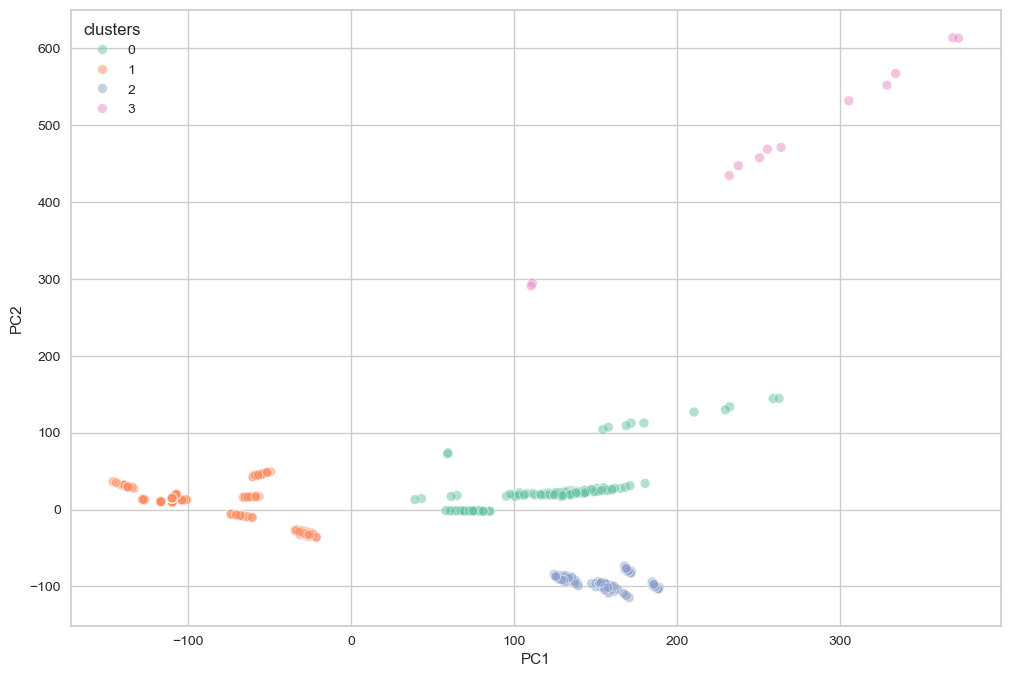

In [192]:
plt.figure(figsize=(12,8))
g = sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="clusters", alpha=0.5, palette="Set2")


<Axes: xlabel='clusters', ylabel='count'>

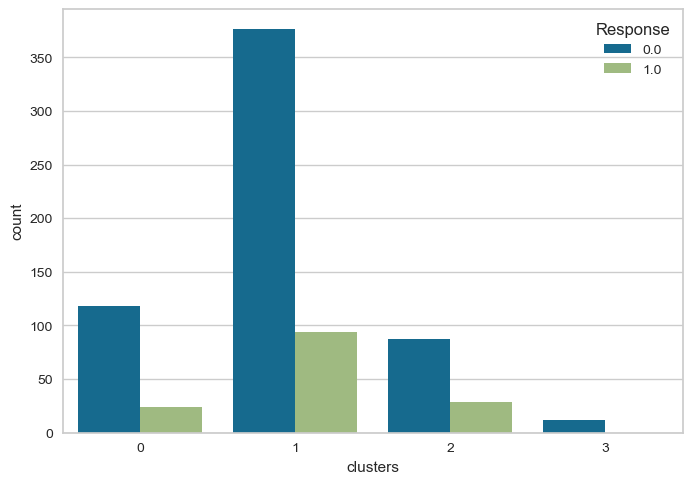

In [193]:
sns.countplot(x = "clusters", hue='Response', data=df_pca)


# 3. Machine learning model to predict drug response

In [194]:
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import make_column_transformer  
from sklearn.pipeline import make_pipeline  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## ML with PCA 

In [196]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)
y = df['Response']  

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [197]:
classifier_scale = [SVC(),
                     KNeighborsClassifier(),
                     GradientBoostingClassifier(n_estimators=100, random_state=42)]

classifier_not_scale = [LogisticRegression(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier()]
    
scaler = StandardScaler()

In [198]:
for classifier in classifier_scale:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

# Evaluate regressors that do not require scaling
for classifier in classifier_not_scale:
    pipe = make_pipeline(classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
     # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

SVC() Accuracy: 81.42%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.89       469
         1.0       0.76      0.15      0.26       123

    accuracy                           0.81       592
   macro avg       0.79      0.57      0.58       592
weighted avg       0.80      0.81      0.76       592

KNeighborsClassifier() Accuracy: 85.47%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91       469
         1.0       0.70      0.53      0.60       123

    accuracy                           0.85       592
   macro avg       0.79      0.73      0.76       592
weighted avg       0.85      0.85      0.85       592

GradientBoostingClassifier(random_state=42) Accuracy: 93.07%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       469
         1.0       0.98      0.68      0.80 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier() Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      1.00      1.00       123

    accuracy                           1.00       592
   macro avg       1.00      1.00      1.00       592
weighted avg       1.00      1.00      1.00       592



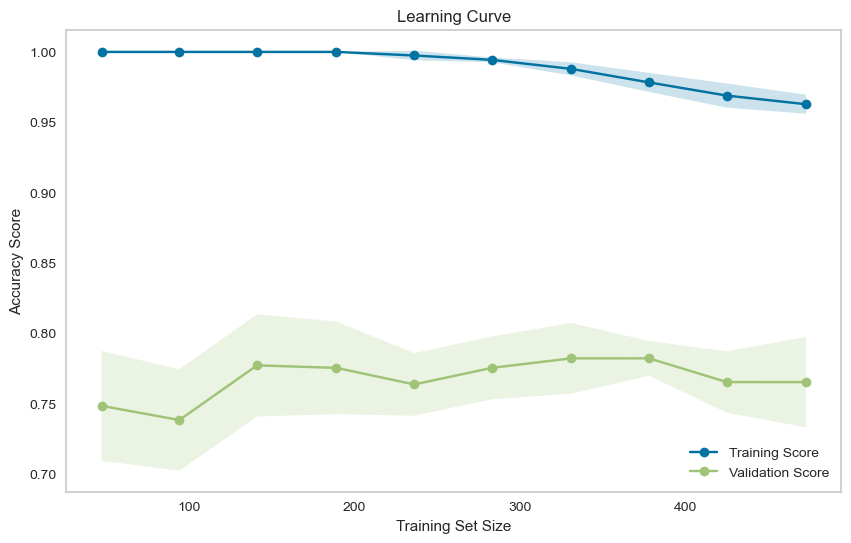

In [199]:
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

## ML with original X

In [208]:
X = df.drop(columns=['Sample ID','Response'], axis=1)
y = df['Response']  

X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [209]:
classifier_scale = [SVC(),
                     KNeighborsClassifier(),
                     GradientBoostingClassifier(n_estimators=100, random_state=42)]

classifier_not_scale = [LogisticRegression(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier()]
    
scaler = StandardScaler()

In [210]:
for classifier in classifier_scale:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

# Evaluate regressors that do not require scaling
for classifier in classifier_not_scale:
    pipe = make_pipeline(classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
     # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))
 
  

SVC() Accuracy: 81.42%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.89       469
         1.0       0.76      0.15      0.26       123

    accuracy                           0.81       592
   macro avg       0.79      0.57      0.58       592
weighted avg       0.80      0.81      0.76       592

KNeighborsClassifier() Accuracy: 87.50%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       469
         1.0       0.75      0.60      0.67       123

    accuracy                           0.88       592
   macro avg       0.82      0.77      0.79       592
weighted avg       0.87      0.88      0.87       592

GradientBoostingClassifier(random_state=42) Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      1.00      1.00

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Accuracy: 91.22%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       469
         1.0       1.00      0.58      0.73       123

    accuracy                           0.91       592
   macro avg       0.95      0.79      0.84       592
weighted avg       0.92      0.91      0.90       592

DecisionTreeClassifier() Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      1.00      1.00       123

    accuracy                           1.00       592
   macro avg       1.00      1.00      1.00       592
weighted avg       1.00      1.00      1.00       592

RandomForestClassifier() Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      1.00      1.00 

##  3.2 Trianing and Evaluation of Model Performance

### KNeighborsClassifier

In [212]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'algorithm': ['auto', 'kd_tree'],
    'p': [1, 2],
    'metric': ['minkowski', 'manhattan']
}

# Instantiate the model
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
Best cross-validation score: 0.8243697478991596


In [ ]:

# Initialize the model with the best parameters
knn = KNeighborsClassifier(**best_params)

# Fit the model to the training data
knn.fit(X_train, y_train)

# If you want to make predictions on the test set
y_pred = knn.predict(X_)

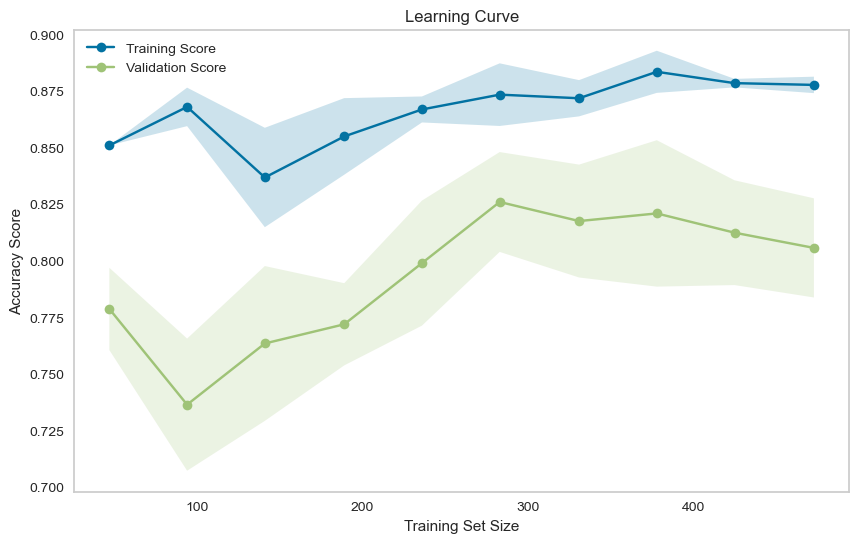

In [214]:
best_params = {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()